# Full Controllability: Falcon-7b

Here we will analyze the results in `ctrl1_falcon7b_*_of_32.csv`. 
 - [ ] Load in all the CSVs, concatenate into 1 big results CSV. 
 - [ ] Plot the portion of uncontrollable instances as a function of $k$. 
 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import glob
import os
from ast import literal_eval

# seaborn 
import seaborn as sns
sns.set(style="whitegrid", palette="muted", color_codes=True)

## Plotting Functions

In [2]:
def add_zero_prompt_length(df_in): 
    # set prompt_length to zero when base_correct is true 
    df_in.loc[df_in['base_correct'] == True, 'prompt_length'] = 0
    return df_in

In [3]:
def overview_report(df_in): 
    print("Mean prompt correct (epsilon): \t", df_in['prompt_correct'].mean())
    print("Mean prompt correct with k <= 4: ", len(df_in[df_in['prompt_length'] <= 4]) / len(df_in))
    print("Mean base correct: \t\t", df_in['base_correct'].mean())
    print("Mean prompt length: \t\t", df_in['prompt_length'].mean())


In [4]:
def k_epsilon_line_plot(df_in,
                        title="TITLE",
                        output_path=None, 
                        figsize=(6, 4), 
                        log_y=False): 
    # Placeholder for the final percentages
    results = []

    # For each unique question_length
    question_lengths = df_in['question_length'].unique().tolist()
    question_lengths.sort()
    for q_len in question_lengths:
        # Filter the dataframe
        temp_df = df_in[df_in['question_length'] == q_len]

        percentage_correct = []
        prompt_lengths = sorted(temp_df['prompt_length'].unique())
        prompt_lengths = [0] + prompt_lengths
        for p_len in prompt_lengths:
            # Calculate the percentage for this prompt_length
            portion = temp_df[temp_df['prompt_length'] <= p_len]
            correct = portion['prompt_correct'].sum()
            total = len(temp_df)
            percentage = 1-(correct/total)
            percentage_correct.append((p_len, percentage))

        results.append((q_len, percentage_correct))

    # Plotting
    plt.figure(figsize=figsize)

    for q_len, percentages in results:
        x, y = zip(*percentages)
        y = np.array(y)
        plt.plot(x, y, label=f'Question Length {q_len}')

    plt.xlabel('Prompt Length [k]')

    
    
    # logarithmic y-axis 
    if log_y: 
        plt.yscale('log')
        plt.ylabel('Log(Portion Incorrect) [log(epsilon)]')
    else:
        plt.ylabel('Portion Incorrect [epsilon]')

    plt.title(title)
    plt.legend()
    plt.grid(True)
    # plt.yscale('log')
    if output_path is not None:
        plt.savefig(output_path, dpi=300)
    return results


In [5]:
def loss_k_correlation_plots(df_in, 
                             suptitle="TITLE", 
                             output_path=None, 
                             figsize=(8, 9)):
    solved_df = df_in[df_in['prompt_correct'] == 1]
    question_lengths = solved_df['question_length'].unique().tolist()
    question_lengths.sort()

    # make a 3 by 2 grid of plots
    fig, axs = plt.subplots(3, 2, figsize=figsize, sharex=True, sharey=True)
    # sharex and sharey
    print(question_lengths)
    # plot a scatter plot of base_correct vs. prompt_length
    for idx_, q_len in enumerate(question_lengths):
        # Filter the dataframe
        temp_df = df_in[df_in['question_length'] == q_len]
        idx = idx_ + 1
        axs[idx//2, idx%2].scatter(temp_df['base_loss'], temp_df['prompt_length'], alpha=0.5)
        axs[idx//2, idx%2].set_xlabel('Base Loss')
        axs[idx//2, idx%2].set_ylabel('Prompt Length [k]')

        # compute the Pearson correlation coefficient between base_loss and prompt_length
        corr = temp_df['base_loss'].corr(temp_df['prompt_length'])
        print(f'Pearson correlation coefficient (q_len={q_len}): {corr}')
        axs[idx//2, idx%2].set_title(f'Question Len {q_len}: Corr={corr:.2f}')

    # Now we add the overall plot in axs[0,0] 
    axs[0,0].scatter(solved_df['base_loss'], solved_df['prompt_length'], alpha=0.5, c='r')    
    axs[0,0].set_xlabel('Base Loss')
    axs[0,0].set_ylabel('Prompt Length [k]')
    corr = solved_df['base_loss'].corr(solved_df['prompt_length'])
    axs[0,0].set_title(f'All Question Lengths -- Corr={corr:.2f}')
    corr = solved_df['base_loss'].corr(solved_df['prompt_length'])

    # tight layout
    plt.suptitle(suptitle)
    plt.tight_layout()

    if output_path is not None:
        plt.savefig(output_path, dpi=300)
    


In [6]:
def get_prompt_token_freqs(df_in, 
                           tokenizer, 
                           num_to_prompt=20, 
                           title="TITLE", 
                           figsize=(12, 3), 
                           output_path=None): 
    prompt_tokens = df_in[df_in['base_correct'] == False]['best_prompt_ids'].tolist()
    prompt_tokens = [literal_eval(x) for x in prompt_tokens]
    all_prompt_tokens = []
    for x in prompt_tokens: 
        all_prompt_tokens += x
    
    # all_prompt_tokens is a list of all the prompt tokens (including duplicates). 
    # We want to count the number of times each token appears in the list.
    # We can use a dictionary to do this.
    prompt_token_freqs = {}
    for token in all_prompt_tokens:
        if token in prompt_token_freqs:
            prompt_token_freqs[token] += 1
        else:
            prompt_token_freqs[token] = 1

    # now let's sort the dictionary by value
    prompt_token_freqs = {k: v for k, v in sorted(prompt_token_freqs.items(), key=lambda item: item[1], reverse=True)}


    # Let's plot the top 20 tokens
    top_20_tokens = list(prompt_token_freqs.keys())[:num_to_prompt]
    top_20_freqs = list(prompt_token_freqs.values())[:num_to_prompt]

    plt.figure(figsize=figsize)
    plt.bar([i for i in range(num_to_prompt)], top_20_freqs)
    plt.xticks([i for i in range(num_to_prompt)], [tokenizer.decode([x]) for x in top_20_tokens], rotation=90)
    plt.xlabel('Token')
    plt.ylabel('Frequency')
    plt.title(title)

    plt.tight_layout()

    if output_path is not None:
        plt.savefig(output_path, dpi=300)

    return prompt_token_freqs


## Falcon-7b Controllability

In [7]:
# Load in the CSV -- use glob to get all CSVs of the name `ctrl1_falcon7b_*_of_32.csv`
path = r'ctrl1_falcon7b_*_of_32.csv'
all_files = glob.glob(path)
li = []

# Iterate through all files and append to a list
for filename in all_files:
    df = pd.read_csv(filename, index_col=None, header=0)
    li.append(df)

# Concatenate all files into one DataFrame
df_falcon_7b = pd.concat(li, axis=0, ignore_index=True)
df_falcon_7b.head()

,question,question_ids,answer,answer_ids,base_loss,search_method,best_prompt,best_prompt_ids,prompt_length,prompted_loss,base_correct,prompt_correct,question_length
0,take back what is Dalmasca's. He is a cheerfu...,"[980, 743, 637, 304, 15767, 88, 41726, 204, 18...",asleep,15630,16.8750,gcg,Verdict,"[64453, 27488, 21455, 1751, 5129, 15630, 28587...",10,0.000298,False,True,32
1,now eastern Hampshire had been placed under Æ...,"[849, 16896, 22666, 618, 650, 5394, 813, 767, ...",Indie,48380,17.3750,gcg,Sto,"[36329, 61043, 8146, 51116, 16166, 42960, 4679...",10,0.859375,False,True,32
2,dialogue ) to other Capcom titles such as Vie...,"[12797, 204, 20, 271, 599, 4963, 994, 9997, 96...",deport,22104,17.7500,gcg,+(,"[39916, 59458, 50604, 4, 18, 22104, 49705, 882...",10,0.621094,False,True,32
3,"form of the Box, as developed by the Germans ...","[1052, 275, 248, 7864, 204, 23, 345, 4027, 431...",Basket,19932,15.3125,gcg,Hung,"[45629, 31124, 7801, 22581, 7307, 44386, 25747...",8,0.466797,False,True,32
4,destruction was completed by Whig forces in e...,"[13342, 398, 5326, 431, 882, 318, 6389, 272, 2...",Ranch,19948,21.6250,gcg,�,"[8421, 19948, 36578, 38438, 30952, 52678, 2557...",10,2.859375,False,False,32


Outputting the CSV to `ctrl1_k10_falcon_7b_1250.csv`.

In [8]:
output_csv_path = 'ctrl1_k10_falcon7b_1250.csv'
if os.path.exists(output_csv_path):
    print(f'WARNING: {output_csv_path} already exists. Skipping.')
else: 
    df_falcon_7b.to_csv(output_csv_path, index=False, lineterminator='\n')

In [9]:
overview_report(df_falcon_7b)

Mean prompt correct (epsilon): 	 0.5127388535031847
Mean prompt correct with k <= 4:  0.14251592356687898
Mean base correct: 		 0.0
Mean prompt length: 		 8.297770700636942


In [10]:
# What fraction had base_correct true? 
df['base_correct'].value_counts(normalize=True)

base_correct
False    1.0
Name: proportion, dtype: float64

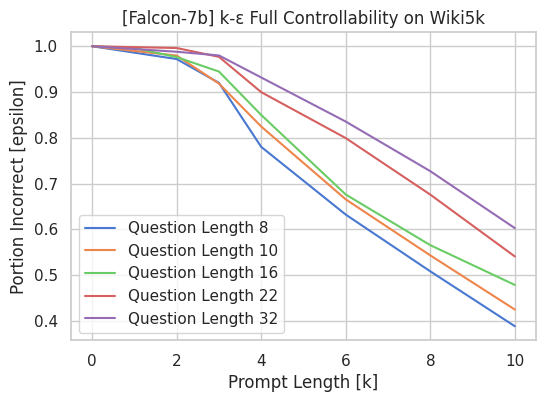

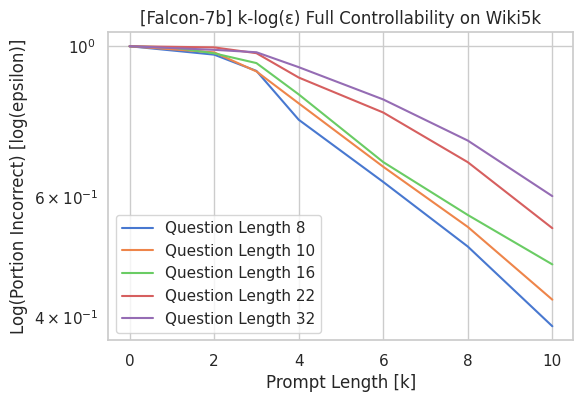

In [11]:
results = k_epsilon_line_plot(df_falcon_7b,
                    title="[Falcon-7b] k-ε Full Controllability on Wiki5k",
                    output_path='line_plot.pdf')


results_log = k_epsilon_line_plot(df_falcon_7b,
                    title="[Falcon-7b] k-log(ε) Full Controllability on Wiki5k",
                    output_path='log_line_plot.pdf',
                    log_y=True)


[8, 10, 16, 22, 32]
Pearson correlation coefficient (q_len=8): 0.42580475925185546
Pearson correlation coefficient (q_len=10): 0.38470428926000216
Pearson correlation coefficient (q_len=16): 0.4813202805893628
Pearson correlation coefficient (q_len=22): 0.3431951076233555
Pearson correlation coefficient (q_len=32): 0.3667600438039036


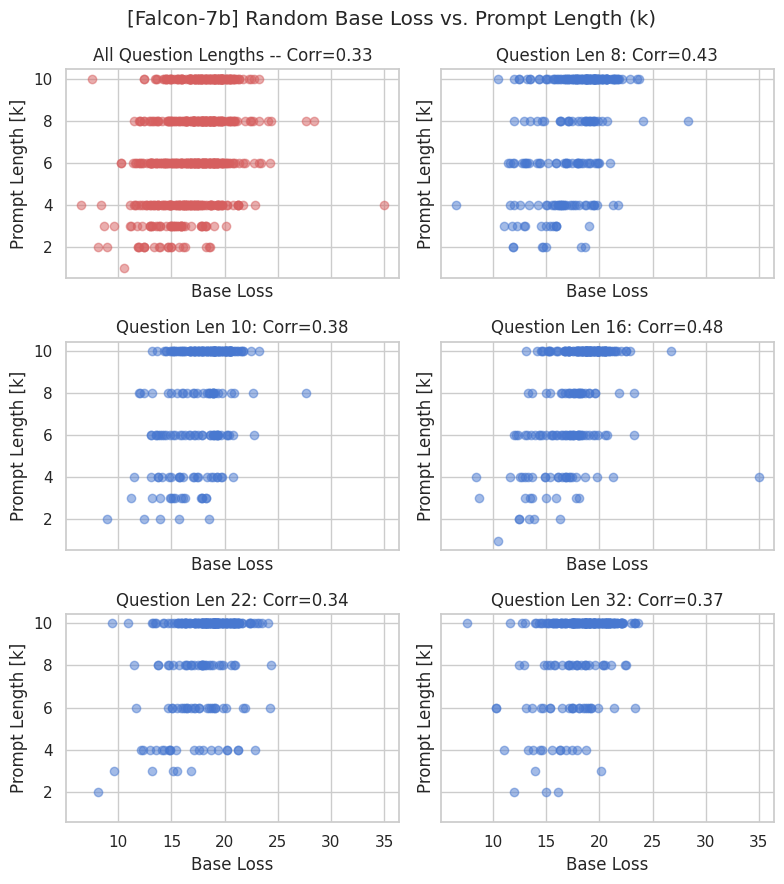

In [12]:
loss_k_correlation_plots(df_falcon_7b, 
                         suptitle="[Falcon-7b] Random Base Loss vs. Prompt Length (k)", 
                         output_path='base_loss_vs_prompt_length.pdf')


## Rank vs. Prompt Length

Let's plot the rank of the next token logit versus the required prompt length k. 

This will inform our experiments where we restrict the desired next token to a 
set defined via the logits (e.g., top $z$ logits). 

In [80]:
# load the `ctrl_ranked_k10_falcon7b_1250.csv` file
df_falcon_7b_ranked = pd.read_csv('ctrl1_ranked_k10_falcon7b_1250.csv')
df_falcon_7b_ranked.head()

,question,question_ids,answer,answer_ids,base_loss,search_method,best_prompt,best_prompt_ids,prompt_length,prompted_loss,base_correct,prompt_correct,question_length,base_logits,base_rank,base_entropy
0,"the outgoing President, saying, "" For myself ...","[248, 33750, 3503, 204, 23, 3225, 204, 23, 204...",techn,18355,21.125,gcg,scientific,"[6963, 18355, 381, 25161, 29904, 37984, 24804,...",8,1.867188,False,True,32,"[-14.0, -14.375, -16.375, -17.125, -11.6875, -...",54278,2.334805
1,"Friends. Six members of the public, named Bar...","[13725, 204, 25, 12732, 2094, 275, 248, 1202, ...",absor,60729,19.625,gcg,lockdown,"[15332, 49857, 1977, 28818, 46937, 23562, 75, ...",10,9.125000,False,False,32,"[-15.9375, -18.5, -21.125, -19.375, -10.5625, ...",44684,2.186432
2,"( 54 @,@ 000 sq ft ) was closed for investiga...","[204, 19, 204, 6698, 204, 43, 23, 43, 204, 132...",volunteers,11537,15.625,gcg,unstable,"[29372, 46031, 1233, 45702, 61792, 41541, 1105...",10,0.333984,False,True,32,"[-17.625, -18.75, -18.125, -18.375, -10.8125, ...",14308,3.882855
3,"around the New Zealand battalion, which was s...","[1111, 248, 1184, 10891, 59603, 204, 23, 585, ...",patriotic,49411,18.125,gcg,Feedback,"[47368, 49411, 39447, 8888, 23220, 51461]",6,0.236328,False,True,32,"[-16.625, -19.25, -20.0, -19.375, -11.8125, -1...",19248,0.622347
4,factors were attributed with Oxford's substan...,"[4561, 646, 20750, 335, 14068, 204, 18, 94, 10...",ministre,54971,19.500,gcg,\n,"[33791, 27860, 53782, 60300, 996, 28128, 44863...",10,12.187500,False,False,32,"[-16.625, -16.625, -18.75, -16.875, -12.625, -...",35741,1.476131


Pearson correlation coefficient: 0.25


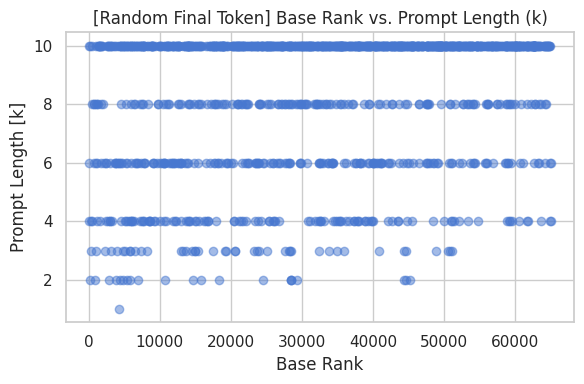

In [81]:
# Let's view the relationship between base_rank and prompt_length 
plt.figure(figsize=(6, 4))
plt.scatter(df_falcon_7b_ranked['base_rank'], df_falcon_7b_ranked['prompt_length'], alpha=0.5)
plt.xlabel('Base Rank')
plt.ylabel('Prompt Length [k]')
plt.title('[Random Final Token] Base Rank vs. Prompt Length (k)')
plt.tight_layout()

# Print the pearson correlation
corr = df_falcon_7b_ranked['base_rank'].corr(df_falcon_7b_ranked['prompt_length'])
print(f'Pearson correlation coefficient: {corr:.2f}')

Length of solved_df:  644
Pearson correlation coefficient: 0.19


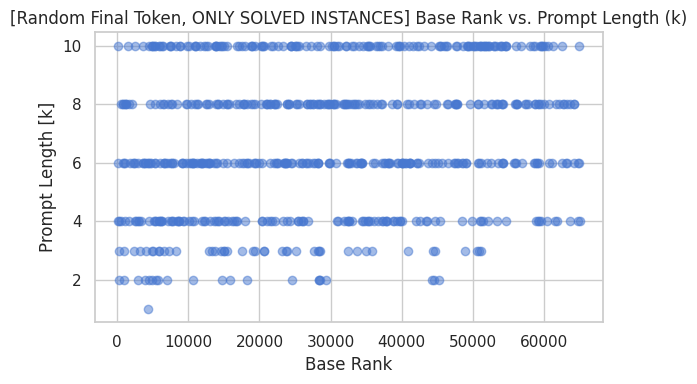

In [59]:
# Let's see the same thing but only for the "solved" instances
solved_df = df_falcon_7b_ranked[df_falcon_7b_ranked['prompt_correct'] == 1]
print("Length of solved_df: ", len(solved_df))

plt.figure(figsize=(6, 4))
plt.scatter(solved_df['base_rank'], solved_df['prompt_length'], alpha=0.5)
plt.xlabel('Base Rank')
plt.ylabel('Prompt Length [k]')
plt.title('[Random Final Token, ONLY SOLVED INSTANCES] Base Rank vs. Prompt Length (k)')
plt.tight_layout()

# Print the pearson correlation
corr = solved_df['base_rank'].corr(solved_df['prompt_length'])
print(f'Pearson correlation coefficient: {corr:.2f}')

In [ ]:
# can we train a classifier to predict whether a prompt is solvable or not 
# based on base_loss, base_rank, and base_entropy? 
# Goal: predict 'prompt_correct' from 'base_loss', 'base_rank', and 'base_entropy'
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
# try an MLP too 
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score

# Split into train and test
X = df_falcon_7b_ranked[['base_loss', 'base_rank', 'base_entropy']]
y = df_falcon_7b_ranked['prompt_correct']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

clf = LogisticRegression(random_state=0).fit(X_train, y_train)
y_pred = clf.predict(X_test)



# what fraction of the test set is solvable?
print("Fraction of test set that is solvable: ", y_test.mean())
# what fraction of the training set is solvable
print("Fraction of training set that is solvable: ", y_train.mean())




print("=== LINEAR REGRESSION FOR PREDICTING SOLVABILITY WITH K<10 -- RANDOM FINAL TOKEN ===")
print("Accuracy: ", accuracy_score(y_test, y_pred))
print("Precision: ", precision_score(y_test, y_pred))
print("Recall: ", recall_score(y_test, y_pred))
print("F1: ", f1_score(y_test, y_pred))

=== LINEAR REGRESSION FOR PREDICTING SOLVABILITY WITH K<10 -- RANDOM FINAL TOKEN ===
Accuracy:  0.6111111111111112
Precision:  0.6115107913669064
Recall:  0.6589147286821705
F1:  0.6343283582089552


Fraction of test set that is solvable:  0.5119047619047619
Fraction of training set that is solvable:  0.5129482071713147


In [ ]:
# Now let's try an MLP and SVM classifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC

# MLP
# clf = MLPClassifier(random_state=1, max_iter=300).fit(X_train, y_train)
# y_pred = clf.predict(X_test)

# print("=== MLP FOR PREDICTING SOLVABILITY WITH K<10 ===")
# print("Accuracy: ", accuracy_score(y_test, y_pred))
# print("Precision: ", precision_score(y_test, y_pred))
# print("Recall: ", recall_score(y_test, y_pred))
# print("F1: ", f1_score(y_test, y_pred))


# SVM
clf = SVC(random_state=1, kernel='poly', degree=4, C=1000.0).fit(X_train, y_train)
y_pred = clf.predict(X_test)

print("=== SVM FOR PREDICTING SOLVABILITY WITH K<10 ===")
print("Accuracy: ", accuracy_score(y_test, y_pred))
print("Precision: ", precision_score(y_test, y_pred))
print("Recall: ", recall_score(y_test, y_pred))
print("F1: ", f1_score(y_test, y_pred))

# compute + print training set loss
y_pred = clf.predict(X_train)
print("\n\n=== SVM FOR PREDICTING SOLVABILITY WITH K<10 (TRAINING SET) ===")
print("Accuracy: ", accuracy_score(y_train, y_pred))
print("Precision: ", precision_score(y_train, y_pred))
print("Recall: ", recall_score(y_train, y_pred))
print("F1: ", f1_score(y_train, y_pred))


=== SVM FOR PREDICTING SOLVABILITY WITH K<10 ===
Accuracy:  0.5119047619047619
Precision:  0.5119047619047619
Recall:  1.0
F1:  0.6771653543307087


=== SVM FOR PREDICTING SOLVABILITY WITH K<10 (TRAINING SET) ===
Accuracy:  0.5129482071713147
Precision:  0.5129482071713147
Recall:  1.0
F1:  0.6780776826859776


## Predictability of Control on Original Reachability

```bash
>>> python3 scripts/add_logits.py \
    --input_file results/reachability/k10_falcon7b_wiki5k.csv \
    --output_file results/reachability/ranked_k10_falcon7b_wiki5k.csv \
    --model falcon-7b
```

Now let's do what we did above with the csv in `../reachability/ranked_k10_falcon7b_wiki5k.csv`

In [61]:
file_path = '../../reachability/ranked_k10_falcon7b_wiki5k.csv'
reach_df_falcon_7b_ranked = pd.read_csv(file_path, lineterminator='\n')

In [43]:
reach_df_falcon_7b_ranked['base_entropy'][0]

4.17173348069705

Pearson correlation coefficient: 0.12


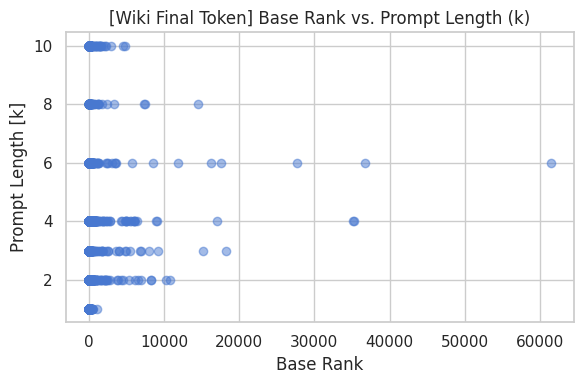

In [44]:
# Let's view the relationship between base_rank and prompt_length 
plt.figure(figsize=(6, 4))
plt.scatter(reach_df_falcon_7b_ranked['base_rank'], reach_df_falcon_7b_ranked['prompt_length'], alpha=0.5)
plt.xlabel('Base Rank')
plt.ylabel('Prompt Length [k]')
plt.title('[Wiki Final Token] Base Rank vs. Prompt Length (k)')
plt.tight_layout()

# Print the pearson correlation
corr = reach_df_falcon_7b_ranked['base_rank'].corr(reach_df_falcon_7b_ranked['prompt_length'])
print(f'Pearson correlation coefficient: {corr:.2f}')

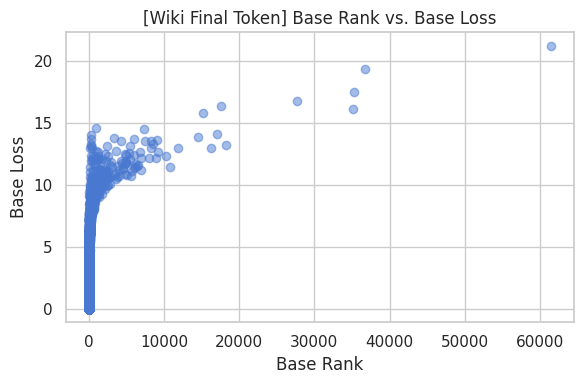

In [45]:
# plot base rank vs. base_loss 
plt.figure(figsize=(6, 4))
plt.scatter(reach_df_falcon_7b_ranked['base_rank'], reach_df_falcon_7b_ranked['base_loss'], alpha=0.5)
plt.xlabel('Base Rank')
plt.ylabel('Base Loss')
plt.title('[Wiki Final Token] Base Rank vs. Base Loss')
plt.tight_layout()


In [64]:
reach_df_falcon_7b_ranked.columns

Index(['question', 'question_ids', 'answer', 'answer_ids', 'base_prediction',
       'base_loss', 'search_method', 'best_prompt', 'best_prompt_ids',
       'prompt_length', 'prompted_loss', 'base_correct', 'prompt_correct',
       'question_length', 'base_logits', 'base_rank', 'base_entropy'],
      dtype='object')

In [73]:
# can we train a regressor to predict the required prompt length  based on
# base_loss, base_rank, and base_entropy? 
# Goal: predict 'prompt_length' from 'base_loss', 'base_rank', and 'base_entropy'
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
# try an MLP too 
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, mean_squared_error, mean_absolute_error

# Split into train and test
X = reach_df_falcon_7b_ranked[['base_loss', 'base_rank', 'base_entropy']]

# normalize X
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
X = scaler.fit_transform(X)

y = reach_df_falcon_7b_ranked['prompt_length']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# linear regression -- continuous y values
from sklearn.linear_model import LinearRegression
reg = LinearRegression().fit(X_train, y_train)
y_pred = reg.predict(X_test)

print("=== LINEAR REGRESSION FOR PREDICTING PROMPT LENGTH WITH K<10 ===")
print("R^2: ", reg.score(X_test, y_test))
print("Mean squared error: ", mean_squared_error(y_test, y_pred))
print("Mean absolute error: ", mean_absolute_error(y_test, y_pred))




=== LINEAR REGRESSION FOR PREDICTING PROMPT LENGTH WITH K<10 ===
R^2:  0.38251620483798454
Mean squared error:  3.1233590026236873
Mean absolute error:  0.972382506323413


In [79]:
len(reach_df_falcon_7b_ranked[reach_df_falcon_7b_ranked['base_correct'] == True])

2104